(Note that all units unless otherwise mentioned are SI units.)

In [1]:
import numpy as np
from skimage import io
from skimage.restoration import unwrap_phase
import prop
import matplotlib.pyplot as plt
import pickle
import prop

Importing all the required libraries.

step_xy 1.00010001e-08
energy(in eV) 5000
wavelength in m 2.47968e-10
focal_length 0.006
zp_coords (-50, 50, -50, 50)
delta 0.00012143
beta 2.6233e-05


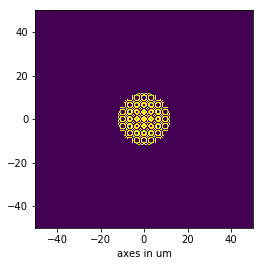

In [2]:
zp = np.load('Au_100_zp.npy')
parameters = pickle.load(open('parameters_Au_100.pickle','rb'))
for i in parameters : print(i,parameters[i])
zp_coords = parameters['zp_coords']
plt.imshow(zp,extent=zp_coords)
plt.xlabel('axes in um')
plt.show()

Importing zone plate pattern and the parameters associated with it.

In [3]:
'''
decide whether to use TF or IR approach depending on the distance
'''
def decide(step_z,step_xy,L,wavel):
    dist = step_z
    sampling = step_xy
    critical = wavel*dist/L
    if sampling > critical :
        p = prop.propTF
        print('propogator to be used : TF')
    else :
        p = prop.propIR
        print('propogator to be used : IR')
    return p   
'''
used as part of the multislice loop
'''
def modify(wavefront,zp_delta,zp_beta,step_z,wavel):
    dist = step_z
    kz = 2 * np.pi * dist /wavel
    beta_slice = zp_beta
    delta_slice = zp_delta
    new_wavefront = wavefront * np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    return new_wavefront
'''
perform free space propogation using the method decided above
'''
def propogate(wavefront,step_xy,step_z,L,wavel,p):
    sampling = step_xy
    dist = step_z
    return p(wavefront,sampling,L,wavel,dist)

*decide* : decides whether TF or IR approach should be used for propogation
* *Inputs* : step size in z, step size in xy, support length, wavelength
* *Outputs* : propogator
    
*modify* : wavefront is modified according to the material present
* *Inputs* : wavefront, slice properties (here the zone plate),step size in z , wavelength
* *Outputs* : modified wavefront

*propogate* : wavefront is propogated for the specified distance
* *Inputs* : wavefront, step size in z, step size in xy, wavelength, propogator
* *Outputs* : wavefront at output plane


In [4]:
zp_beta  = parameters['beta']*zp
zp_delta = parameters['delta']*zp
step_xy = parameters['step_xy']
energy = parameters['energy(in eV)']
wavel = parameters['wavelength in m']
f = parameters['focal_length']
wavefront = np.ones(np.shape(zp),dtype='complex64') 
L = step_xy*np.shape(zp)[0] 
m,n = np.shape(zp)
zp_thickness = 1000e-9      

*Setting up the parameters for the simulation*<br>
* *zp_beta and zp_delta* : delta and beta grid for the zone plate <br>
* *step_xy*              : sampling in the xy plane<br>
* *wavel*                : wavelength<br>
* *f*                    : focal length<br>
* *wavefront*            : wavefront that is initialzed with magnitude of 1 and phase of 0<br>
* *L*                    : support length<br>
* *m,n*                  : dimensions of input zp<zp>
* *zp_thickness*         : thickness of zone plate <br>

In [5]:
eps1 = 0.1
eps2 = 0.1
delta_z_suggested = ((eps2*(step_xy**2))/(eps1**2*wavel))
number_of_steps_zp = int(np.ceil(zp_thickness/delta_z_suggested))
print('suggested step size :',delta_z_suggested)
print('number of steps required for propogation through the zone plate :',number_of_steps_zp)

suggested step size : 4.03358509971e-06
number of steps required for propogation through the zone plate : 1


Determining the step size in the z direction (direction of propogation) using the meteric described in *Optics Express Vol. 25, Issue 3, pp. 1831-1846*

In [6]:
step_z = zp_thickness/number_of_steps_zp
wavefront = np.ones(np.shape(zp),dtype='complex64') #initialize wavefront 
p = decide(step_z,step_xy,L,wavel)
for i in range(number_of_steps_zp):
    wavefront = modify(wavefront,zp_delta,zp_beta,step_z,wavel)
    wavefront  = p(wavefront,step_xy,L,wavel,step_z)
wavefront_exit = wavefront

propogator to be used : TF


*Propogating the wavefront through the zone plate using the number of steps as determined above*<br>
* *step_z*         : step size in direction of propogation (using the above result)<br>
* *p*              : propogator to be used<br>
* *wavefront_exit* : wavefront as it leaves the zone plate

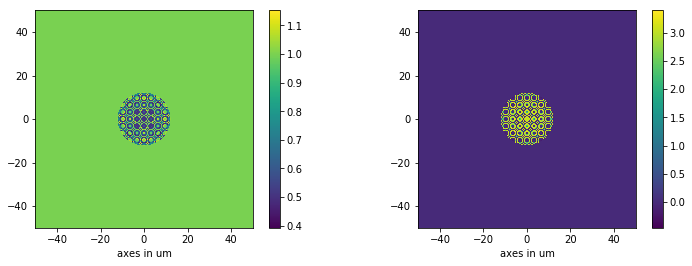

magnitude(left) and phase(right) of the exit wave


In [7]:
fig, (ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow(abs(wavefront_exit),extent = zp_coords)
fig.colorbar(im1,ax = ax1)
ax1.set_xlabel('axes in um')
im2 = ax2.imshow(unwrap_phase(np.angle(wavefront_exit)),extent = zp_coords)
fig.subplots_adjust(right=1.75)
ax2.set_xlabel('axes in um')
fig.colorbar(im2,ax = ax2)
plt.show()
print('magnitude(left) and phase(right) of the exit wave')

In [8]:
step_z = f
p = decide(step_z,step_xy,L,wavel)
print(step_xy,wavel)
print('Fresnel Number :',((50e-6*50e-6)/(wavel*step_z)))
wavefront_focus  = p(wavefront_exit,step_xy,L,wavel,step_z)

propogator to be used : IR
1.00010001e-08 2.47968e-10
Fresnel Number : 1680.3243429259687


*Propogating the wavefront to the focal plane in one step*<br>
step_z          : focal length<br>
wavefront_focus : wavefront at the focus

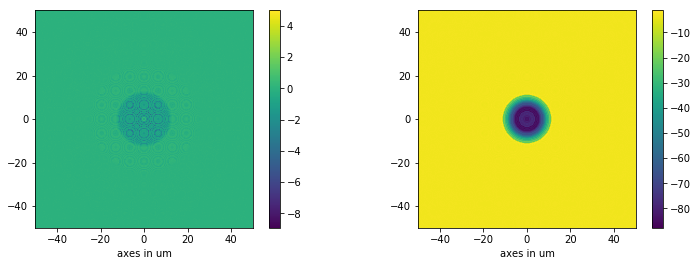

magnitude(in log scale)(left) and phase(right) of the wave in the focal plane
maximum value of wavefront in focal plane :  147.521556651
minimum value of wavefront in focal plane :  0.000133224734065
location of maxima in focal plane :  (array([5000]), array([5000]))


In [9]:
fig, (ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow(np.log(abs(wavefront_focus)),extent = zp_coords)
fig.colorbar(im1,ax = ax1)
ax1.set_xlabel('axes in um')
im2 = ax2.imshow(unwrap_phase(np.angle(wavefront_focus)),extent = zp_coords)
fig.subplots_adjust(right=1.75)
ax2.set_xlabel('axes in um')
fig.colorbar(im2,ax = ax2)
plt.show()
print('magnitude(in log scale)(left) and phase(right) of the wave in the focal plane')
print('maximum value of wavefront in focal plane : ',np.max(abs(wavefront_focus)))
print('minimum value of wavefront in focal plane : ',np.min(abs(wavefront_focus)))
print('location of maxima in focal plane : ',np.where(abs(wavefront_focus)==np.max(abs(wavefront_focus))))

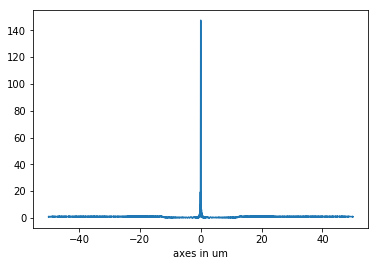

slice in x-direction along the focal spot


In [10]:
x = np.linspace(zp_coords[0],zp_coords[1],n)
plt.plot(x,abs(wavefront_focus)[5000,:])
plt.xlabel('axes in um')
plt.show()
print('slice in x-direction along the focal spot')